# Data Analysis for 3DUI Honours Project Rotation Controllers
_By Steven Rybicki_

## Introduction

In [5]:
%matplotlib inline
import json
import os
import math
import csv
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd 
pd.options.display.max_colwidth = 500
from datetime import datetime
from scipy import stats
from collections import defaultdict, namedtuple
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [238]:
TASK_STAGES = [
    12,
    17,
    22
]

TRAINING_STAGES = [
    10,
    15,
    20
]

CONTROLLER_OPTIONS = [["discrete", "twoaxis", "arcball"], 
                      ["discrete", "arcball", "twoaxis"], 
                      ["twoaxis", "discrete", "arcball"], 
                      ["twoaxis", "arcball", "discrete"], 
                      ["arcball", "discrete", "twoaxis"], 
                      ["arcball", "twoaxis", "discrete"]]

MODEL_OPTIONS = [["models/mrt_model.json", "models/mrt_model_16a.json", "models/mrt_model_23a.json"], 
                 ["models/mrt_model.json", "models/mrt_model_23a.json", "models/mrt_model_16a.json"], 
                 ["models/mrt_model_16a.json", "models/mrt_model.json", "models/mrt_model_23a.json"], 
                 ["models/mrt_model_16a.json", "models/mrt_model_23a.json", "models/mrt_model.json"], 
                 ["models/mrt_model_23a.json", "models/mrt_model.json", "models/mrt_model_16a.json"], 
                 ["models/mrt_model_23a.json", "models/mrt_model_16a.json", "models/mrt_model.json"]]

INSPECTION_MODELS = ["models/ico_sphere_model_1.json",  
                     "models/ico_sphere_model_2.json", 
                     "models/ico_sphere_model_3.json", 
                     "models/ico_sphere_model_4.json", 
                     "models/ico_sphere_model_5.json"]

ORIENTATION_TASK_QUAT = {
    "0_0": [0.25881904510252074,0,0,0.9659258262890683],
    "0_1": [0,0,0.7071067811865475,0.7071067811865476],
    "0_2": [0.3314135740355918,0.4619397662556433,0.19134171618254486,0.8001031451912656],
    "0_3": [0.2185080122244105,0.21850801222441052,0.6724985119639573,0.6724985119639574],
    "1_0": [0.04799966634373737,0.7856544802373238,0.11573312388031406,-0.6058456187435991],
    "1_1": [-0.9124677834418226,0.3563393717894529,0.16246581417319952,-0.11844684680693215],
    "1_2": [0.060676044258967846,0.7425536630010398,-0.09767856431944423,-0.6598419305328469]
}

INSPECTION_TASK_QUAT = {
   # Right
   "2_4": [
        {"_x": 0.6037360617406411, "_y": 0.4867887259157211, "_z": 0.4852088982653913, "_w": -0.4038710550650234}, # i
        {"_x": -0.11248894296227391, "_y": 0.06028303996174144, "_z": -0.003373189735094837, "_w": 0.9918169258463039}, # ii       
        {"_x": -0.11174826532646152, "_y": -0.027786247141969745, "_z": -0.013321632568326447, "_w": 0.9932586691149524}, #ii
        {"_x": -0.7811102408938534, "_y": -0.01961503471099203, "_z": 0.1175362952920859, "_w": 0.6129170101025461}, # iii
        {"_x": -0.780783276818326, "_y": -0.07268886885317291, "_z": 0.050768701649669366, "_w": 0.6184790553595897}, # iii
        {"_x": -0.7749035265933994, "_y": -0.12204774719510819, "_z": -0.013785769906469866, "_w": 0.6200313092302658} # iii
    ],
    # Left
    "2_3":[
        {"_x": -0.00833871292136609, "_y": 0.7652087852958418, "_z": 0.004063556581182305, "_w": 0.6437153627813997}, # i
        {"_x": 0.1948499334671147, "_y": 0.754113368097429, "_z": 0.6162279869611768, "_w": 0.11666018845513774}, # ii
        {"_x": -0.14839942688648336, "_y": -0.7638058622785789, "_z": -0.6034981656185071, "_w": -0.1742646807122343}, # ii
        {"_x": 0.20596119891012116, "_y": -0.7545924538373429, "_z": 0.6200211133045981, "_w": -0.06118849738120929}, # iii
        {"_x": -0.1547361282111554, "_y": 0.7675820165970251, "_z": -0.609426932862735, "_w": 0.124392089477525}, # iii
        {"_x": 0.10206975688214842, "_y": -0.7753229466686666, "_z": 0.5947228958245248, "_w": -0.1864424047289847}, # iii
    ],
    # Back
    "2_2" : [
        {"_x": -0.029613511273988227, "_y": -0.9959613034779483, "_z": 0.08453278757996126, "_w": 0.006191102364907987}, # i
        {"_x": -0.11540244522140938, "_y": 0.045397514405298656, "_z": 0.01901363990593801, "_w": 0.9920986961085412}, # ii
        {"_x": -0.112556321254479, "_y": -0.0346808803313726, "_z": 0.009551699101593052, "_w": 0.9929939960187937}, # ii
        {"_x": -0.03859961323541416, "_y": -0.7750926112640198, "_z": -0.12904713390161232, "_w": 0.6173235383927773}, # iii
        {"_x": -0.0837200176668557, "_y": -0.7725081123897988, "_z": -0.07063207613090679, "_w": 0.6254864385062631}, # iii
        {"_x": -0.1309944396554082, "_y": -0.7652335446523579, "_z": -0.013966990216109457, "_w": 0.6301293534683624}, # iii
    ],
    # Top
    "2_1": [
        {"_x": 0.7409727890022544, "_y": 0.23941413588589777, "_z": 0.19895308004920917, "_w": 0.5950276207329898}, # i
        {"_x": 0.7266398312917077, "_y": -0.26958936361201574, "_z": 0.5838591535971657, "_w": 0.24171185194033912}, # ii
        {"_x": -0.7066543608643184, "_y": 0.3123196225137307, "_z": -0.6060865997818791, "_w": -0.18909019337121336}, # ii
        {"_x": 0.6506928948316127, "_y": 0.4389487590260925, "_z": -0.25264848979678445, "_w": -0.56576628051565}, # iii
        {"_x": -0.6771995348130961, "_y": -0.3935147540315883, "_z": 0.30914304984814234, "_w": 0.5394233060769378}, # iii
        {"_x": -0.7023921164512765, "_y": -0.346548889764243, "_z": 0.36262006731939933, "_w": 0.5050305619737696}, # iii
    ],
    # Bottom
    "2_0": [
        {"_x": 0.7820467470152829, "_y": -0.034745384642642985, "_z": 0.0002240369371546896, "_w": -0.6222504267064023}, # i
        {"_x": 0.11044866065596898, "_y": -0.046994740721513086, "_z": 0.6864112877260672, "_w": -0.7172392430605443}, # ii
        {"_x": -0.05217425432717972, "_y": 0.10775035835081356, "_z": -0.679589110432064, "_w": 0.7237584876482142}, # ii
        {"_x": -0.4482753257179445, "_y": -0.6226779602416613, "_z": 0.42678939225293583, "_w": -0.478719338278834}, # iii
        {"_x": -0.4845375784017118, "_y": -0.594916507823405, "_z": 0.3853577861896457, "_w": -0.5126373576504399}, # iii
        {"_x": -0.5169595621635281, "_y": -0.5664420353830509, "_z": 0.3440537794764716, "_w": -0.5417778405091477}, # iii
    ]
}

MRT_ANSWERS =\
    [[1, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [1, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [2, 4],
    [1, 4],
    [3, 4],
    [2, 3],
    [1, 2],
    [2, 4],
    [2, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [1, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [1, 4],
    [1, 3]]
    
CONFOUNDING_CAT_COLS = [
    "controller_choice",
    "model_choice",
    "Biological Sex",
    "Faculty",
    "Major",
    "What type of computer software do you own or use?  [Word processing]",
    "What type of computer software do you own or use?  [Statistics programs]",
    "What type of computer software do you own or use?  [Games]",
    "What type of computer software do you own or use?  [Art/drawing]",
    "Do you participate in any extra-curricular sports?",
    "Do you own any video game systems?",
    "Do you own a computer?",
    "How long have you owned/been using a computer?",
    "Frequency of use [Using a computer]",
    "Frequency of use [Purchasing software]",
    "Frequency of use [Use the internet]",
    "Frequency of use [Use any video game systems]",
    "Frequency of use [Play boardgames]",
    "Frequency of use [Use maps]",
    "Frequency of use [Use 3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]",
    "Proficiency or Skill [Using maps]",
    "Proficiency or Skill [Using computers]",
    "Proficiency or Skill [Playing video games]",
    "Proficiency or Skill [3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]",
    "Level of Degree"
] 

CONFOUNDING_NUM_COLS = [
    "Age",
    "How many science courses (or modules) have you taken in the past year? (Please don't include maths courses in this total)",
    "How many maths courses (or modules) have you taken in the past year?",
    "What was your final Matric mark for Maths?",
    "What was your final Matric mark for English?",
]
    
CONTROLLERS = ["twoaxis","arcball","discrete"]

PRETTY_NAMES = {
    "q_0_0 accuracy":"Simple Matching X Accuracy",
    "q_0_1 accuracy":"Simple Matching Z Accuracy",
    "q_0_2 accuracy":"Simple Matching X+Y Accuracy",
    "q_0_3 accuracy":"Simple Matching Y+Z Accuracy",
    "q_1_0 accuracy":"Complex Matching 1 Accuracy",
    "q_1_1 accuracy":"Complex Matching 2 Accuracy",
    "q_1_2 accuracy":"Complex Matching 3 Accuracy",
    "q_2_0 accuracy":"Inspection Face 1 Accuracy",
    "q_2_1 accuracy":"Inspection Face 2 Accuracy",
    "q_2_2 accuracy":"Inspection Face 3 Accuracy",
    "q_2_3 accuracy":"Inspection Face 4 Accuracy",
    "q_2_4 accuracy":"Inspection Face 5 Accuracy",
    "q_0_0 time":"Simple Matching X Time",
    "q_0_1 time":"Simple Matching Z Time",
    "q_0_2 time":"Simple Matching X+Y Time",
    "q_0_3 time":"Simple Matching Y+Z Time",
    "q_1_0 time":"Complex Matching 1 Time",
    "q_1_1 time":"Complex Matching 2 Time",
    "q_1_2 time":"Complex Matching 3 Time",
    "q_2_0 time":"Inspection Face 1 Time",
    "q_2_1 time":"Inspection Face 2 Time",
    "q_2_2 time":"Inspection Face 3 Time",
    "q_2_3 time":"Inspection Face 4 Time",
    "q_2_4 time":"Inspection Face 5 Time",
    "q_0_0 score":"Simple Matching X Score",
    "q_0_1 score":"Simple Matching Z Score",
    "q_0_2 score":"Simple Matching X+Y Score",
    "q_0_3 score":"Simple Matching Y+Z Score",
    "q_1_0 score":"Complex Matching 1 Score",
    "q_1_1 score":"Complex Matching 2 Score",
    "q_1_2 score":"Complex Matching 3 Score",
    "q_2_0 score":"Inspection Face 1 Score",
    "q_2_1 score":"Inspection Face 2 Score",
    "q_2_2 score":"Inspection Face 3 Score",
    "q_2_3 score":"Inspection Face 4 Score",
    "q_2_4 score":"Inspection Face 5 Score",
    "q_0":"I think that I would like to use this system frequently",
    "q_1":"I found the system unnecessarily complex",
    "q_2":"I thought the system was easy to use",
    "q_3":"I think that I would need the support of a technical person to be able to use this system",
    "q_4":"I found the various functions in this system were well integrated",
    "q_5":"I thought there was too much inconsistency in this system",
    "q_6":"I would imagine that most people would learn to use this system very quickly",
    "q_7":"I found the system very cumbersome to use",
    "q_8":"I felt very confident using the system",
    "q_9":"I needed to learn a lot of things before I could get going with this system",
    "anova_p_val": "Anova P Value",
    "kruskal_p_val": "Kruskal-Wallis H-Test p-value",
}

DIRECTORY = "/Users/stevenrybicki/rotation-data-analysis/data/study"
FACTOR_FILE = "/Users/stevenrybicki/rotation-data-analysis/data/study/.info.csv"
LATEX_OPTIONS = {
    "float_format": lambda x: "{0:.2f}".format(x)
}

In [31]:
Event = namedtuple('Event', ["meta", "data"])
EventMeta = namedtuple('EventMeta', ["uuid","pipeline_index","participant_number", "date"])
EventData = namedtuple('EventData', ["raw"])
MRTData = namedtuple('MRTData', ["marks", "score"])
SUSData = namedtuple('SUSData', ["marks", "adj_marks", "score", "total", "controller", "text"])
TaskData = namedtuple('TaskData', ["meta", "info", "score"]);
TaskMeta = namedtuple('TaskMeta', ["type", "num", "repetition", "date"])
TaskInfo = namedtuple('TaskInfo', ["controller", "group", "index", "model", "rotation", "quaternion"])
TaskScore = namedtuple('TaskScore', ["time", "accuracy"])
Experiment = namedtuple('Experiment', ["num", "controllers", "models", "controller_choice", "model_choice"])

In [32]:
# Mathematics objects used for calculating accuracy 

class Vector3(object):
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
    def to_tuple(self):
        return (self.x, self.y, self.z)
    
    def inner_prod(self, v):
        """
        Essentially a dot product
        """
        return sum(a*b for a,b in zip(self.to_tuple(), v.to_tuple()))
    
    def tait_to_q(self):
        """
        Treats the contents of the Vector as Tait-Bryan angles, and converts them to a quaternion
        """
        x,y,z = self.to_tuple()
        x = x / 2.0
        y = y / 2.0
        z = z / 2.0
        e_0 = np.cos(z) * np.cos(y) * np.cos(x) + np.sin(z) * np.sin(y) * np.sin(x)
        e_1 = np.cos(z) * np.cos(y) * np.sin(x) - np.sin(z) * np.sin(y) * np.cos(x)
        e_2 = np.cos(z) * np.sin(y) * np.cos(x) + np.sin(z) * np.cos(y) * np.sin(x)
        e_3 = np.sin(z) * np.cos(y) * np.cos(x) - np.cos(z) * np.sin(y) * np.sin(x)
        return Quaternion(e_1, e_2, e_3, e_0)

class Quaternion(Vector3):
    def __init__(self, x, y, z, w):
        super(Quaternion, self).__init__(x, y, z)
        self.w = w
    
    def to_tuple(self):
        return super(Quaternion, self).to_tuple() + (self.w,)
    
    def dist(self, q):
        """
        What is the minimum angle that would be required to convert this quaternion to q?
        """
        return np.arccos(2 * (self.inner_prod(q)**2) - 1)
    
    def inspec_dist(self, q):
        """
        Given these two quaternions, what is the minimum angle to between the two quaternions if we don't care about
        z rotations in the final axis?
        """
        eu_1 = self.to_tait()
        eu_2 = q.to_tait()
        eu_1.z = 0
        eu_2.z = 0
        eq_1 = eu_1.tait_to_q()
        eq_2 = eu_2.tait_to_q()
        return eq_1.dist(eq_2)
        
    def to_tait(self):
        """
        Convert this quaternion to a vector containing the Tait Bryan angles
        """
        e_1, e_2, e_3, e_0 = self.to_tuple()
        x_rot = np.arctan2((e_2 * e_3 + e_0 * e_1),1/2.0 - (e_1 ** 2 + e_2 ** 2))
        y_rot = np.arcsin(-2 * (e_1 * e_3 - e_0 * e_2))
        z_rot = np.arctan2((e_1 * e_2 + e_0 * e_3), 1/2.0 - (e_2 ** 2 + e_3 ** 2))
        return Vector3(x_rot, y_rot, z_rot)

In [33]:
# Functions for loading the data into people

def get_data(directory):
    """
    Gets the parsed json data for each file in the directory
    """
    def person_num_from(path):
        """
        Get the number from the path
        """
        return path.split("/")[-1].split(".")[0]
    
    def parse_path(path):
        """
        Takes a path, reads it in, gives back the JSON
        """
        data = None
        with open(path) as f:
            file_data = "\n".join(f.readlines()).strip() # remove final newline
            file_data = file_data[1:-1] # remove quotation signs
            data = json.loads(file_data)
        return data
    
    def paths(directory):
        """
        Gives all the paths in the directory that don't begin with "."
        """
        return list(
            map(
                lambda x: "{0}/{1}".format(directory, x), 
                filter(lambda x: x[0] != ".", os.listdir(directory))
            )
        )
    
    return list(
        map(
            lambda x: (person_num_from(x), parse_path(x)), 
            paths(directory))
    )

def get_factors(path):
    """
    Parse the factors file
    """
    factors = dict()
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            num = row["Participant no"]
            proc_row = {}
            for col in row:
                if col in CONFOUNDING_NUM_COLS and row[col]:
                    proc_row[col] = float(row[col]) 
                else:
                    proc_row[col] = row[col]
                    
            factors[num] = proc_row
    return factors

def build_people(data, factors):
    """
    From parsed json data, get a list of people
    """
    people = dict()
    for path, datum in data:
        for event in datum:
            person_num = path
            experiment_num = None
            meta = event[2]
            if "participant_number" in meta:
                experiment_num = meta["participant_number"]
            if person_num and experiment_num:
                if person_num not in people:
                    people[person_num] = Person(person_num, experiment_num)
                    if person_num in factors:
                        people[person_num].factors = factors[person_num]
                        
                people[person_num].add_event(event)
            
    return people

def process():
    """
    Convience function for running the above data processing functions on the specified folders/files
    """
    full_data = get_data(DIRECTORY)
    factors = get_factors(FACTOR_FILE)
    people = build_people(full_data, factors)
    return people

In [34]:
# Helper data processing functions

def gen_experiment(num):
    """
    Determine the order in which controllers and models were presented to a participant with a given number
    """
    controller_num = num % len(CONTROLLER_OPTIONS)
    model_num = int(num / len(MODEL_OPTIONS)) % len(MODEL_OPTIONS)
    controller_choice = CONTROLLER_OPTIONS[controller_num]
    model_choice = MODEL_OPTIONS[model_num]
    return Experiment(num, controller_choice, model_choice, controller_num, model_num)

def parse_date(js_date):
    """
    Example input date: "2015-09-03T20:03:09.429Z"
    This is then transformed to
    2015-09-03 20:03:09

    Which is then made into a python datetime object
    Gives all the paths in the directory that don't begin with "."
    """
    template = "%Y-%m-%d %H:%M:%S.%f"
    formatted_date = js_date.replace("T"," ").replace("Z","") + "000"
    return datetime.strptime(formatted_date, template)

class Person:
    """
    All the data for an individual person
    """
    def __init__(self, person_num, experiment_num):
        self.person_num = person_num # unique identifying number
        self.experiment = gen_experiment(experiment_num)
        self.events = []
        self.mrt_results = None
        self.sus_results = dict()
        self.tasks = defaultdict(lambda : defaultdict(dict))
        self.training_tasks = defaultdict(lambda : defaultdict(dict))
        self.factors = dict()
        self.event_fns = (
            ("mrt test results", self.process_mrt),
            ("sus evaluation results", self.process_sus),
            ("saving user task", self.process_task),
        )

    def process_mrt(self, event_meta, event_data):
        """
        Given an event containing MRT data, set the person's MRT results and return the marked MRT
        """
        if self.mrt_results:
            raise "Duplicate MRT results for {0}".format(self.person_num)
            
        template = "test_{0}_{1}"
        data = event_data[1]
        marks = []
        for i, answers in enumerate(MRT_ANSWERS):
            answer_1 = template.format(i, answers[0])
            answer_2 = template.format(i, answers[1])
            if all([((answer in data) and data[answer]) for answer in (answer_1, answer_2)]):
                marks.append(True)
            else:
                marks.append(False)
                
        mrt_data = MRTData(marks, marks.count(True))
        self.mrt_results = mrt_data
        return mrt_data

    def process_sus(self, event_meta, event_data):
        """
        Given an event containing SUS data, set the controller's SUS results and return the processed SUS data
        """
        controller = event_data[1]
        if controller in self.sus_results:
            raise "duplicate controller for {0}".format(self.person_num)
            
        # Load events
        data = event_data[2]
        marks = [None]*10
        adj_marks = [None]*10
        for key in data:
            if data[key] and key != "text":
               num, answer = [int(x) for x in key.split("_")]
               marks[num] = answer
        
        # Calculate score
        score = 0
        total = 0
        for i in range(len(marks)):
            if marks[i] != None:
                if i % 2 == 0:
                    adj_marks[i] = marks[i]
                else:
                    adj_marks[i] = 5 - (marks[i] + 1)
                score += adj_marks[i]
                total += 4
        score *= 2.5
        total *= 2.5

        sus_data = SUSData(marks, adj_marks, score, total, controller, data["text"] if "text" in data else "")
        self.sus_results[controller] = sus_data
        return sus_data

    def process_task(self, event_meta, event_data):
        # Data we can read straight off given data
        group = event_data[1]
        index = event_data[2]
        rotation = event_data[3]
        quaternion = event_data[4]
        stage = event_meta.pipeline_index
        time = (event_meta.date - self.events[-1].meta.date).total_seconds()

        # Data dependent on stage
        task_type = None
        task_group = None
        repetition = None
        container = None
        if stage in TASK_STAGES:
            task_type = "task"
            repetition = TASK_STAGES.index(stage)
            container = self.tasks
        elif stage in TRAINING_STAGES:
            task_type = "training"
            repetition  = TRAINING_STAGES.index(stage)
            container = self.training_tasks
            
        controller = self.experiment.controllers[repetition]
        model = self.experiment.models[repetition] if group < 2 else INSPECTION_MODELS[index]
        num = len(container[controller])
        
        # Calculate accuracy
        accuracy = None
        key = "{0}_{1}".format(group, index)
        if task_type == "training":
            accuracy = 0 # ignore these for training data
        else:
            their_quat = Quaternion(*quaternion)
            if group < 2:
                task_group = "orientation"
                model_quat = ORIENTATION_TASK_QUAT[key]
                accuracy = Quaternion(*model_quat).dist(their_quat)
            else:
                task_group = "inspection"
                quat = INSPECTION_TASK_QUAT[key][0]
                model_quat = Quaternion(quat["_x"], quat["_y"], quat["_z"], quat["_w"])
                accuracy = model_quat.inspec_dist(their_quat)
                
        if accuracy > math.pi:
            print(accuracy,  2*math.pi - accuracy)
            accuracy = 2*math.pi - accuracy
            
        # Setup tuples
        score = TaskScore(time, accuracy)
        info = TaskInfo(controller, group, index, model, rotation, quaternion)
        meta = TaskMeta(task_group, num, repetition, event_meta.date)
        task_data = TaskData(meta, info, score)
        
        container[controller][group][index] = task_data
        return task_data

    def add_event(self, event):
        event_meta = EventMeta(
                event[2]["uuid"],
                event[2]["pipeline_index"],
                event[2]["participant_number"],
                parse_date(event[1]))

        event_data = EventData(event[3:])
        for name, fn in self.event_fns:
            if name == event[3]:
                event_data = fn(event_meta, event[3:])
                break

        processed_event = Event(event_meta, event_data)
        self.events.append(processed_event)

    def validate(self):
        num_mrt = len(self.mrt_results)
        sus_keys = self.sus_results.keys()
        num_sus = len(self.sus_results)
        totals_sus = [self.sus_results[key].total for key in self.sus_results]
        valid_elms = (
          num_mrt == 1,
          sus_keys == set(CONTROLLERS),
          num_sus == 3,
          all(total == 100 for total in totals_sus),
        )
        valid = all(valid_elms)
        return valid

In [202]:
# Converting people data into dataframes, then manipulating those data frames

def get_df(people):
    """
    Given a list of people, get dataframes to represent them
    """
    people_data = []
    people_indices = []
    task_data = []
    sus_data = []
    for num in people:
        # create person datum
        person = people[num]
        people_indices.append(num)
        person_data = {
            "mrt_score": person.mrt_results.score,
            "controller_choice": person.experiment.controller_choice, 
            "model_choice": person.experiment.model_choice,
            "valid": person.validate()
        }
        
        for factor in person.factors:
            factor_data = person.factors[factor]
            if factor_data: # ignore incompleted questions
                person_data[factor] = person.factors[factor]
        
        people_data.append(person_data)
        
        # create task datum
        for controller in person.tasks:
            for group in person.tasks[controller]:
                for index in person.tasks[controller][group]:
                    task = person.tasks[controller][group][index]
                    measures = (("time", task.score.time),
                                ("accuracy", task.score.accuracy),
                                ("score", task.score.accuracy / task.score.time if task.score.time else np.NAN))

                    for measure_name, measure in measures:
                        task_data.append({
                            "person_num": num,
                            "measure_name": measure_name,
                            "measure_val": measure,
                            "controller": controller,
                            "group": group,
                            "index": index,
                            "type": task.meta.type,
                            "num_done": task.meta.num,
                            "repetition": task.meta.repetition, 
                            "date": task.meta.date,
                            "model": task.info.model,
                            "quaternion": task.info.quaternion
                        })
        
        # create sus datum
        if not all(person.sus_results[controller].total == 100 for controller in CONTROLLERS):
            print("discarding SUS results of ", num)
            continue
        for controller in CONTROLLERS:
            sus_result = person.sus_results[controller]
            sus_datum = {
                "person_num": num,
                "score": sus_result.score,
                "total": sus_result.total,
                "controller": controller,
                "text": sus_result.text,
            }
            for i, mark in enumerate(sus_result.adj_marks):
                sus_datum["q_{0}".format(i)] = mark
            sus_data.append(sus_datum)                

    people_df = pd.DataFrame(people_data, index=people_indices)
    task_df = pd.DataFrame(task_data)
    sus_df = pd.DataFrame(sus_data)
    return (people_df, task_df, sus_df)

In [203]:
people = process()
df = get_df(people)
people_df = df[0]
task_df = df[1]
sus_df = df[2]

sus_df

('discarding SUS results of ', '30')


,controller,person_num,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,score,text,total
0,twoaxis,42,2,1,3,4,3,4,3,2,3,4,72.5,,100
1,arcball,42,3,3,3,4,3,4,3,3,4,4,85.0,,100
2,discrete,42,1,1,2,4,2,4,2,1,2,3,55.0,,100
3,twoaxis,24_b,4,3,3,4,3,3,3,4,4,3,85.0,I found the ability to combine types of movements not useful as firstly the cursor was hidden once the object was selected and I couldn't tell when the type of movement was going to change. Also it was very unlikely that my cursor was near the border of the circle at the specific times when I would have liked to change my type of movement control. It was much easier to keep the inner and out circle motions separate and the change between them in a single motion was a little annoying.,100
4,arcball,24_b,3,3,2,3,4,3,3,3,3,3,75.0,I found that it worked well for the initial rough 3D positional movements but for the fine tuning movements I couldn't stop movement in all 3 dimensions even when I just wanted movement in the xy plane. I reverted somewhat to the 2 axis controller movements by using the very center of the sphere for xy movements (which took longer) and then using the outside of the sphere for pure clockwise/anticlockwise rotations.,100
5,discrete,24_b,3,3,4,3,3,3,2,3,2,1,67.5,,100
6,twoaxis,24_a,3,4,3,4,3,3,4,4,4,4,90.0,"Initially, having become accustomed to the first controller, I found the additional rotation functionality unnecessary. As I continued I became more reliant on the function as it was really handy in some cases. I feel if I were to go back to the first controller now, I would miss the additional functionality. The only drawback and slight inconvenience was that seeing as the pointer disappears when the left mouse button is pressed, if I was using the rotation function it would occasionally dr...",100
7,arcball,24_a,4,4,4,4,4,4,3,4,4,3,95.0,"It took a few attempts to master, but I think this has been the most intuitive system so far, it involved very little thinking which is always nice.",100
8,discrete,24_a,3,4,4,4,4,4,3,4,4,4,95.0,"For someone with relatively good computer skills, this controller is smooth and intuitive",100
9,twoaxis,43,1,3,2,3,3,1,1,1,3,1,47.5,This system is not as logical to use. I was not always sure which direction the object would move in,100


\begin{tabular}{lrrrrrrr}
\toprule
{} &  inspection\_accuracy &  inspection\_score &  inspection\_time &  orientation\_accuracy &  orientation\_score &  orientation\_time &  usability score \\
\midrule
arcball\_median  &                 0.02 &              0.00 &             7.34 &                  0.10 &               0.00 &             19.26 &            82.50 \\
discrete\_median &                 0.02 &              0.00 &             9.12 &                  0.09 &               0.00 &             21.92 &            81.25 \\
f\_chi           &                 1.88 &             24.08 &            41.61 &                 13.51 &              28.58 &              9.91 &             0.32 \\
f\_p\_val         &                 0.39 &              0.00 &             0.00 &                  0.00 &               0.00 &              0.01 &             0.85 \\
twoaxis\_median  &                 0.02 &              0.00 &             7.23 &                  0.10 &               0.01 &        

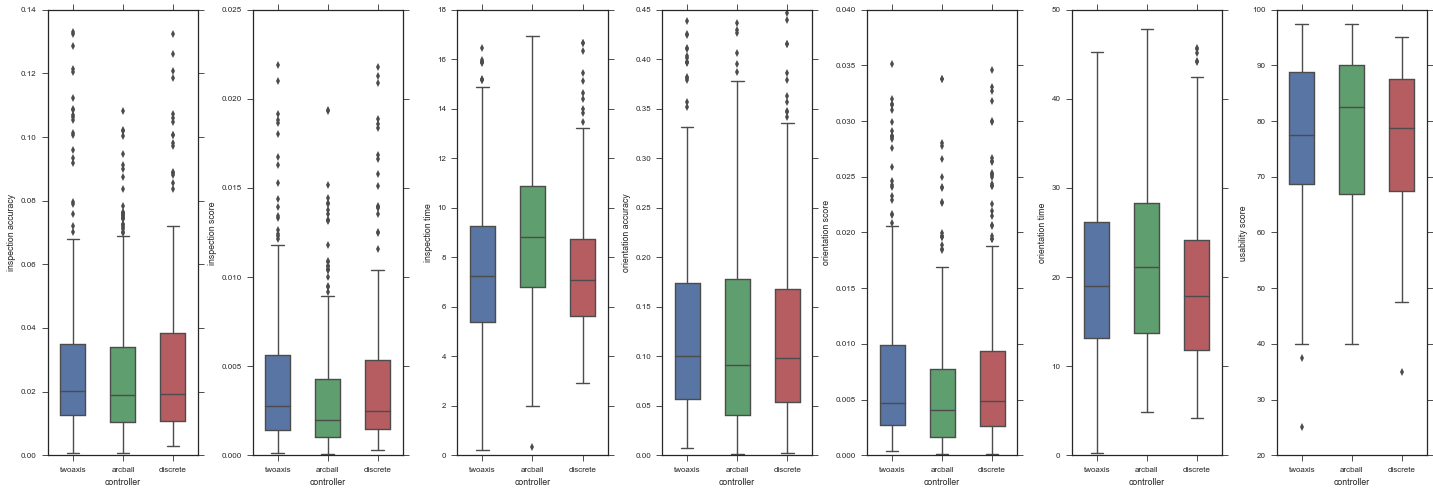

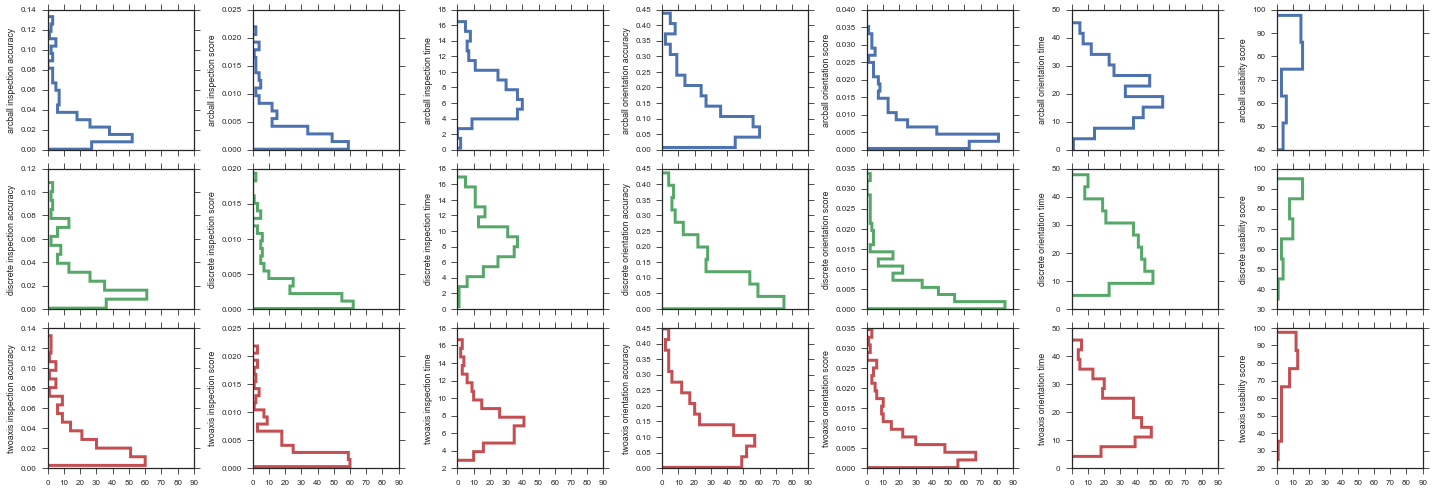

In [249]:
full_tasks_df = task_df.join(people_df, on="person_num")
sns.despine()
sns.set_context("paper")

def report_graphs(groups, usability_score = False, outlier_thresh = 0.95):
    """
    Get the graphs for the given groups!. 
    
    - groups: output of a pandas group_on statement on a task_df compatible object
    - usability_score: do we include usability data with this?
    """
    col_name = lambda n, m: "{0} {1}".format(n, m)
    num_cols = sum(map(lambda x: 1, groups)) * 3
    if usability_score:
        num_cols += 1
        
    def plot_graphs(plot_fn, rows=1, columns=num_cols, figsize=(20, 7), sharex=False):
        f, axes = plt.subplots(rows, columns, figsize=figsize, sharex=sharex)
        i = 0
        for name, g in groups:
            for measure, group in g.groupby("measure_name"):
                filtered_group = group[group.measure_val < group.quantile(outlier_thresh).measure_val].rename(columns={"measure_val": col_name(name, measure)})
                plot_fn(name, measure, filtered_group, axes, i)
                i += 1
        if usability_score:
            filtered_group = sus_df[sus_df.score < sus_df.quantile(1).score].rename(columns={"score":"usability score"})
            plot_fn("usability", "score", filtered_group, axes, i)
            i += 1
            
        plt.setp(axes)
        plt.tight_layout()
        
    box_fn = lambda name, measure, filtered_group, axes, i: \
        sns.boxplot(x="controller", 
                    y=col_name(name, measure), 
                    data=filtered_group, 
                    width=0.5, 
                    ax=axes[i])
    def dist_fn(name, measure, filtered_group, axes, i):
        colours = {
                "arcball": "b",
                "discrete": "g",
                "twoaxis": "r"
        }
        name_fn = lambda c,n,m: "{0} {1}".format(c, col_name(n,m))
        j = 0
        for controller, controller_group in filtered_group.groupby(["controller"]):
            sns.distplot(controller_group[col_name(name, measure)],
                         norm_hist = False,
                         axlabel = name_fn(controller, name, measure),
                         hist=True, 
                         kde=False,
                         ax=axes[j][i], 
                         vertical=True, 
                         hist_kws={"label": [controller], "histtype": "step", "linewidth": 3,
                                   "alpha": 1, "color": [colours[controller]]})
            j += 1
            
            
    plot_graphs(box_fn, sharex=True)
    plot_graphs(dist_fn, rows=3, sharex=True) 

def wil_table(name, measure, values, controllers):
            wilcoxon_table = []
            # Calculate the Wilcoxon entries
            for i in range(len(controllers)):
                con_row = controllers[i]
                for j in range(i + 1, len(controllers)):
                    con_col = controllers[j]
                    T, p = stats.wilcoxon(x=values[i].values, y=values[j].values)             
                    wilcoxon_table.append({
                        "name": name, 
                        "measure": measure,
                        "controllers": con_row + "," + con_col,
                        "median diff": values[i].median() - values[j].median(),
                        "wc_p": p,
                        "wc_t": T})
                        #"sig": p < (0.05/3)})
            return wilcoxon_table

def build_result(values, controllers):
            medians = [v.median() for v in values]
            means = [v.mean() for v in values]
            f_chi, p = stats.friedmanchisquare(*values)
            result = {
                "f_p_val": p,
                "f_chi": f_chi,
                #"sig": p < 0.05
            }
            for controller, median, mean in zip(controllers, medians, means):
                #result["{0}_mean".format(controller)] = mean
                result["{0}_median".format(controller)] = median
            
            for c_name, central_tendency in [("mean", means), ("median", medians)]:
                order_data = [x[1] for x in sorted(zip(central_tendency, controllers))]
                #result["{0}_order".format(c_name)] = order_data
                
            return result    

def report(groups, print_tables=False, usability_score = False):
    """
    Report on the statistical signifance of these different groups. 
    
    - groups: output of a pandas group_on statement on a task_df compatible object
    - usability score: include the usability scores in the report
    """
    results = []
    wilcoxon_table = []
    indices = []
    col_name = lambda n, m: "{0}_{1}".format(n, m)
    # Do task tables
    for name, g in groups:
        for measure, group in g.groupby("measure_name"):
            controllers = []
            values = []
            for controller, controller_group in group.groupby(["controller"]):
                values.append(controller_group["measure_val"])
                controllers.append(controller)
            results.append(build_result(values, controllers))
            indices.append(col_name(name, measure))
            wilcoxon_table += wil_table(name, measure, values, controllers)
            
    # Do sus tables
    if usability_score:
        controllers = []
        values = []
        for controller, controller_group in sus_df.groupby("controller"):
            values.append(controller_group.score)
            controllers.append(controller)
            
        results.append(build_result(values, controllers))
        indices.append("usability score")
        wilcoxon_table += wil_table("usability", "score", values, controllers)
                 
    results_df = pd.DataFrame(results, indices).T
    wilcoxon_df = pd.DataFrame(wilcoxon_table)
    first_run = True
    wilcoxon_table = None
    if print_tables:
        print(results_df.to_latex(**LATEX_OPTIONS))
        for values, group in wilcoxon_df.groupby(["name","measure"]):
            name, measure = values
            g = group[list(set(group.columns) - set(("name", "measure")))]
            g = g.set_index("controllers")
            g.columns = list(map(lambda c: "{0}".format(c, name, measure), g.columns))
            if first_run:
                wilcoxon_table = g
                first_run = False
            else:
                wilcoxon_table = pd.concat([wilcoxon_table, g], axis=1)
        print(wilcoxon_table.to_latex(**LATEX_OPTIONS))
    return(results_df, wilcoxon_df)

# Overall, what is the p value for the different measures? 
report(full_tasks_df.groupby(["type"]), True, True)
report_graphs(full_tasks_df.groupby(["type"]), True)

# Per question, what is the p value for the Friedman test across controllers?
#report(full_tasks_df.groupby(["group","index"]))

# Per possible confounding factor, what is the p value for the Friedman test for the different measures?
#for cat in CONFOUNDING_CAT_COLS:
#    print("Category: {0}".format(cat))
#    report(full_tasks_df.groupby([cat, "type"]), True, False)

# Per possible confoudning factor, what is the p value for the Frieman test for the different questions?
#for cat in CONFOUNDING_CAT_COLS:
#    print("Category: {0}".format(cat))
#    report(full_tasks_df.groupby([cat, "group", "index"]))

In [31]:
task_df[task_df["accuracy"] > 0.6].index

Int64Index([ 194,  202,  220,  221,  222,  241,  243,  245,  246,  269,  286,
             380,  423,  494,  495,  497,  551,  557,  621,  713,  747,  797,
            1001, 1288, 1289, 1310, 1339, 1340, 1341, 1342, 1343, 1351, 1352,
            1353, 1354, 1355, 1359, 1363, 1364, 1365, 1366, 1367, 1430, 1431,
            1432, 1440, 1442, 1443, 1445, 1489, 1490, 1493, 1529, 1558],
           dtype='int64')

In [74]:
import statsmodels.formula.api as smf

def forward_selected(data, response, cols_to_ignore):
    format_col = lambda x: "C(Q(\"{}\"))".format(x) \
                     if x in CONFOUNDING_CAT_COLS \
                     else "Q(\"{}\")".format(x)
    selected_cols = set(data.columns)
    selected_cols.remove(response)
    selected_cols -= set(cols_to_ignore)
    remaining = set(format_col(x) for x in selected_cols)
    formatted_response = format_col(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(formatted_response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        elif current_score == best_new_score:
            break
    formula = "{} ~ {} + 1".format(formatted_response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [75]:
# Finding the best model for task accuracy and time using forward selection
data = task_df.join(people_df, on="person_num")
data = data[data.type == "orientation"]
data = data[data.accuracy < 0.5]

q_cols = ["time", "accuracy", "score"]
cols_to_ignore = q_cols + ["Email Address", "Name (First name and surname)", "Timestamp", "Major", "date", "group", "index", "model", "controller", "person_num", "quaternion", "type", "Participant no", 'valid']
for question_col in q_cols:
    model = forward_selected(data, question_col, cols_to_ignore)
    print(question_col, model.model.formula, model.rsquared_adj)

('time', 'Q("time") ~ C(Q("Do you own any video game systems?")) + C(Q("Do you participate in any extra-curricular sports?")) + Q("How many science courses (or modules) have you taken in the past year? (Please don\'t include maths courses in this total)") + C(Q("What type of computer software do you own or use?  [Statistics programs]")) + Q("repetition") + C(Q("Level of Degree")) + 1', 0.24117550929536913)
('accuracy', 'Q("accuracy") ~ Q("mrt_score") + C(Q("Do you own any video game systems?")) + Q("How many maths courses (or modules) have you taken in the past year?") + Q("How many science courses (or modules) have you taken in the past year? (Please don\'t include maths courses in this total)") + Q("num_done") + C(Q("Proficiency or Skill [Using maps]")) + 1', 0.33679961651910184)
('score', 'Q("score") ~ C(Q("Do you own any video game systems?")) + Q("How many maths courses (or modules) have you taken in the past year?") + Q("How many science courses (or modules) have you taken in the

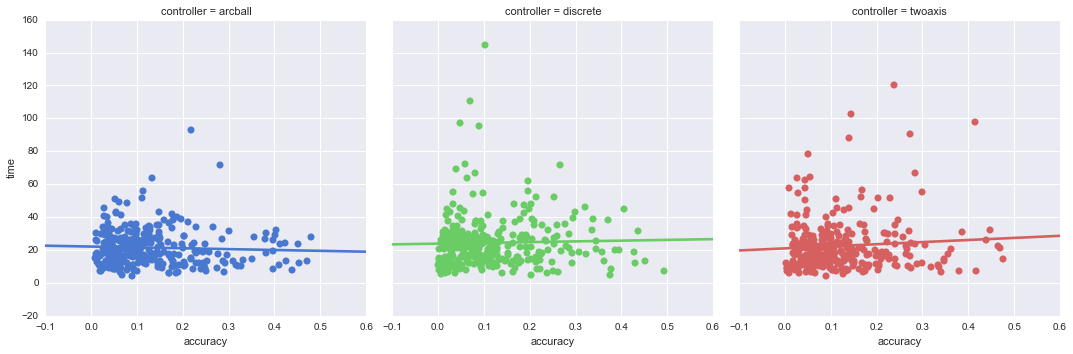

In [17]:
# Take a look at the data
data = task_df.join(people_df, on="person_num")
data = data[data.type == "orientation"]
data = data[data.accuracy < 0.5]

sns.lmplot(x="accuracy", y="time", col="controller", hue="controller", data=data, 
           ci=None, palette="muted", scatter_kws={"s":50, "alpha":1})

# Fit a linear model
formula = 'Q("time") ~ C(Q("Do you own any video game systems?")) + C(Q("Do you participate in any extra-curricular sports?")) + Q("How many science courses (or modules) have you taken in the past year? (Please don\'t include maths courses in this total)") + C(Q("What type of computer software do you own or use?  [Statistics programs]")) + Q("repetition") + C(Q("Level of Degree")) + 1'
lm = ols(formula, data).fit()

# Plot residuals
#infl = lm.get_influence()
#resid = infl.resid_studentized_internal
#sns.distplot(resid, kde=False, color="b")